In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from huggingface_hub import login
from google.colab import userdata
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Optional
from transformers import AutoTokenizer
import re
from datetime import datetime
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from collections import Counter, defaultdict
import random
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import json

In [ ]:
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

Token is valid (permission: read).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

README.md:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

meta_Appliances.jsonl:   0%|          | 0.00/285M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [ ]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


In [ ]:
datapoint = dataset[2]


In [ ]:
datapoint

{'main_category': 'Tools & Home Improvement',
 'title': 'Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504',
 'average_rating': 3.5,
 'rating_number': 18,
 'features': [],
 'description': ['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.'],
 'price': 'None',
 'images': {'hi_res': ['https://m.media-amazon.com/images/I/51TIpnkrEpL._AC_SL1500_.jpg'],
  'large': ['https://m.media-amazon.com/images/I/21HQKcHPIkL._AC_.jpg'],
  'thumb': ['https://m.media-amazon.com/images/I/21HQKcHPIkL._AC_US75_.jpg'],
  'variant': ['MAIN']},
 'videos': {'title': [], 'url': [], 'user_id': []},
 'store': 'GE',
 'categories': ['Appliances', 'Parts & Accessories'],
 'details': '{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Requi

In [ ]:
datapoint_df = pd.DataFrame([datapoint])
datapoint_df.columns

Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
      dtype='object')

In [ ]:
print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504
['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.']
[]
{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Required?": "No", "Best Sellers Rank": {"Tools & Home Improvement": 1315213, "Parts & Accessories": 181194}, "Date First Available": "February 25, 2014"}
None


In [ ]:
prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [ ]:
prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

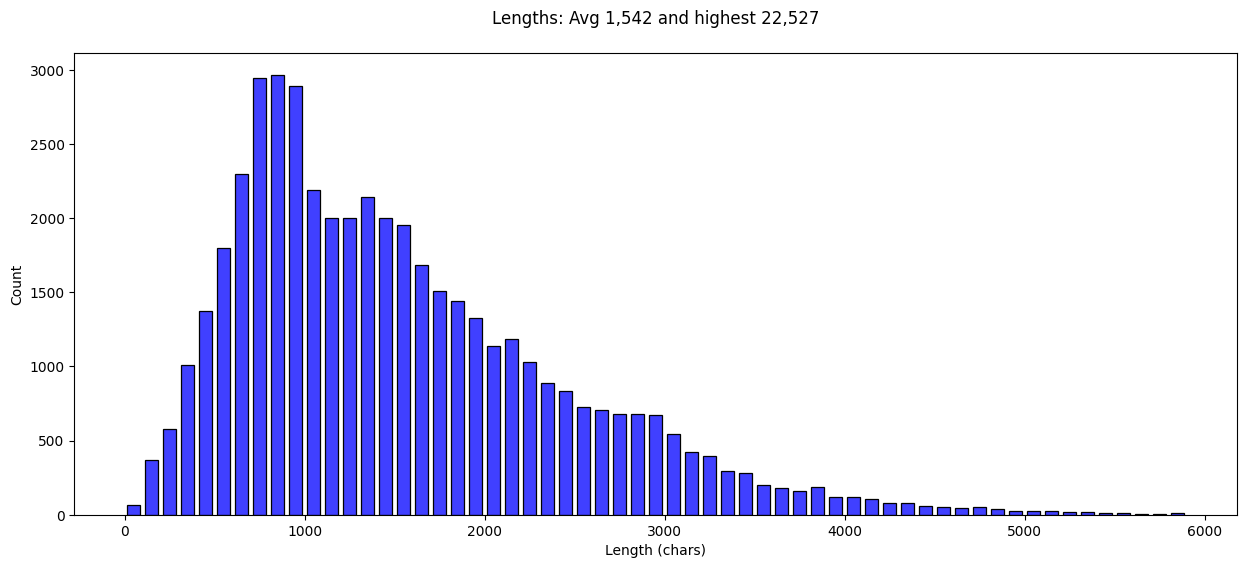

In [ ]:
plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
sns.histplot(lengths, shrink=0.7, color="blue", bins=range(0, 6000, 100))
plt.show()

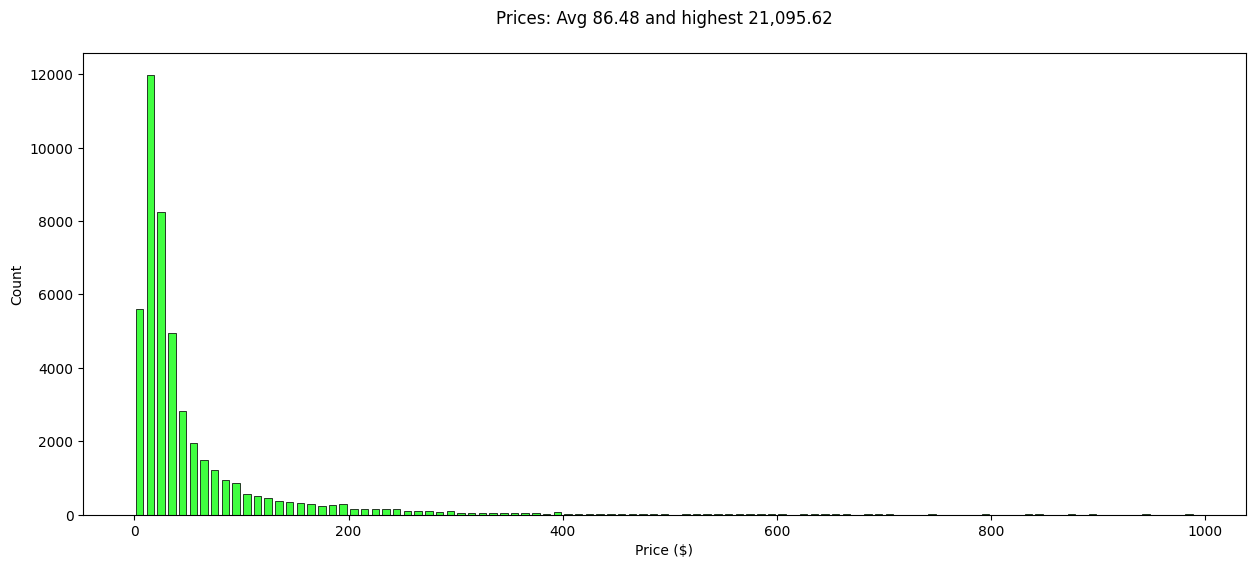

In [ ]:
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
sns.histplot(prices, shrink=0.7, color="lime", bins=range(0, 1000, 10))
plt.show()

In [ ]:
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 21000:
            print(datapoint['title'])
    except ValueError as e:
        pass

TurboChef BULLET Rapid Cook Electric Microwave Convection Oven


In [ ]:
filtered_dataset = dataset.filter(lambda x: x["price"] is not None and x["price"] != 'None' and float(x["price"]) > 21000)
images_of_filtered_dataset = filtered_dataset["images"]

images_of_filtered_dataset

Filter:   0%|          | 0/94327 [00:00<?, ? examples/s]

[{'hi_res': ['https://m.media-amazon.com/images/I/61oZOVndavL._AC_SL1000_.jpg'],
  'large': ['https://m.media-amazon.com/images/I/41rIxEeZKjL._AC_.jpg'],
  'thumb': ['https://m.media-amazon.com/images/I/41rIxEeZKjL._AC_SR38,50_.jpg'],
  'variant': ['MAIN']}]

In [ ]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
MIN_TOKENS = 150
MAX_TOKENS = 160
MIN_CHARS = 300
CEILING_CHARS = MAX_TOKENS * 7

class Item:

    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
    PREFIX = "Price is $"
    QUESTION = "How much does this cost to the nearest dollar?"
    REMOVALS = ['"Batteries Included?": "No"', '"Batteries Included?": "Yes"', '"Batteries Required?": "No"', '"Batteries Required?": "Yes"', "By Manufacturer", "Item", "Date First", "Package", ":", "Number of", "Best Sellers", "Number", "Product "]

    title: str
    price: float
    category: str
    token_count: int = 0
    details: Optional[str]
    prompt: Optional[str] = None
    include = False

    def __init__(self, data, price):
        self.title = data['title']
        self.price = price
        self.parse(data)

    def scrub_details(self):

        details = self.details
        for remove in self.REMOVALS:
            details = details.replace(remove, "")
        return details

    def scrub(self, stuff):

        stuff = re.sub(r'[:\[\]"{}【】\s]+', ' ', stuff).strip()
        stuff = stuff.replace(" ,", ",").replace(",,,",",").replace(",,",",")
        words = stuff.split(' ')
        select = [word for word in words if len(word)<7 or not any(char.isdigit() for char in word)]
        return " ".join(select)

    def parse(self, data):

        contents = '\n'.join(data['description'])
        if contents:
            contents += '\n'
        features = '\n'.join(data['features'])
        if features:
            contents += features + '\n'
        self.details = data['details']
        if self.details:
            contents += self.scrub_details() + '\n'
        if len(contents) > MIN_CHARS:
            contents = contents[:CEILING_CHARS]
            text = f"{self.scrub(self.title)}\n{self.scrub(contents)}"
            tokens = self.tokenizer.encode(text, add_special_tokens=False)
            if len(tokens) > MIN_TOKENS:
                tokens = tokens[:MAX_TOKENS]
                text = self.tokenizer.decode(tokens)
                self.make_prompt(text)
                self.include = True

    def make_prompt(self, text):

        self.prompt = f"{self.QUESTION}\n\n{text}\n\n"
        self.prompt += f"{self.PREFIX}{str(round(self.price))}.00"
        self.token_count = len(self.tokenizer.encode(self.prompt, add_special_tokens=False))

    def test_prompt(self):

        return self.prompt.split(self.PREFIX)[0] + self.PREFIX

    def __repr__(self):

        return f"<{self.title} = ${self.price}>"

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [ ]:
items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 29,191 items


In [ ]:
items[1]

<WP67003405 67003405 Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces AP6010352 8208254 PS11743531 - Quick DIY Repair Solution = $16.52>

In [ ]:
print(items[1].prompt)

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.00


In [ ]:
print(items[1].test_prompt())

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $


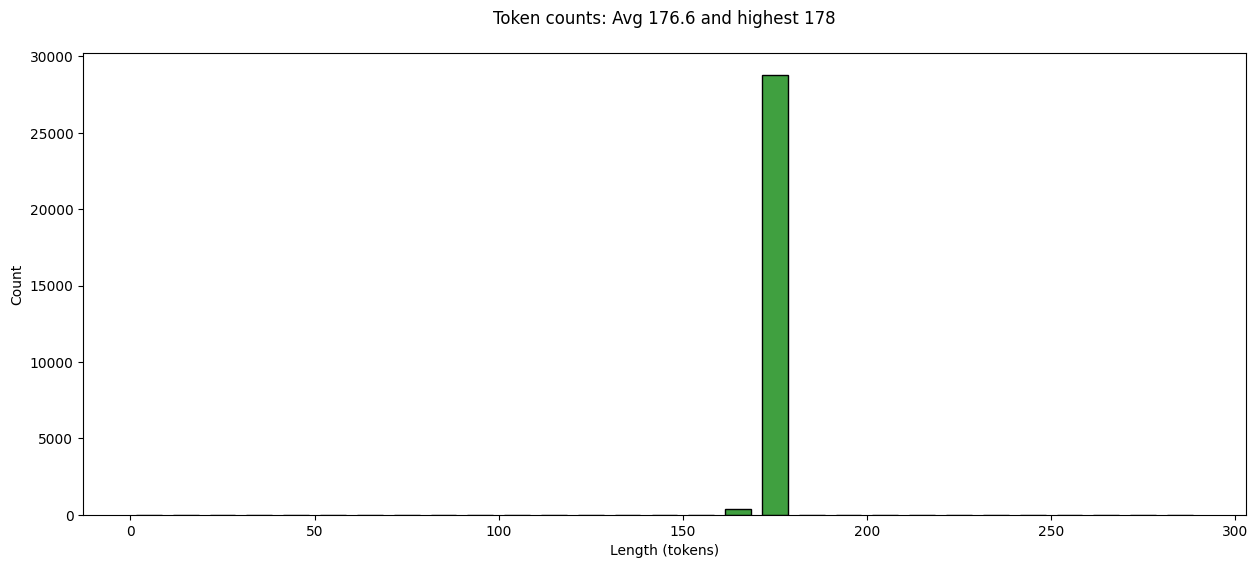

In [ ]:
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
sns.histplot(tokens, shrink=0.7, color="green", bins=range(0, 300, 10))
plt.show()

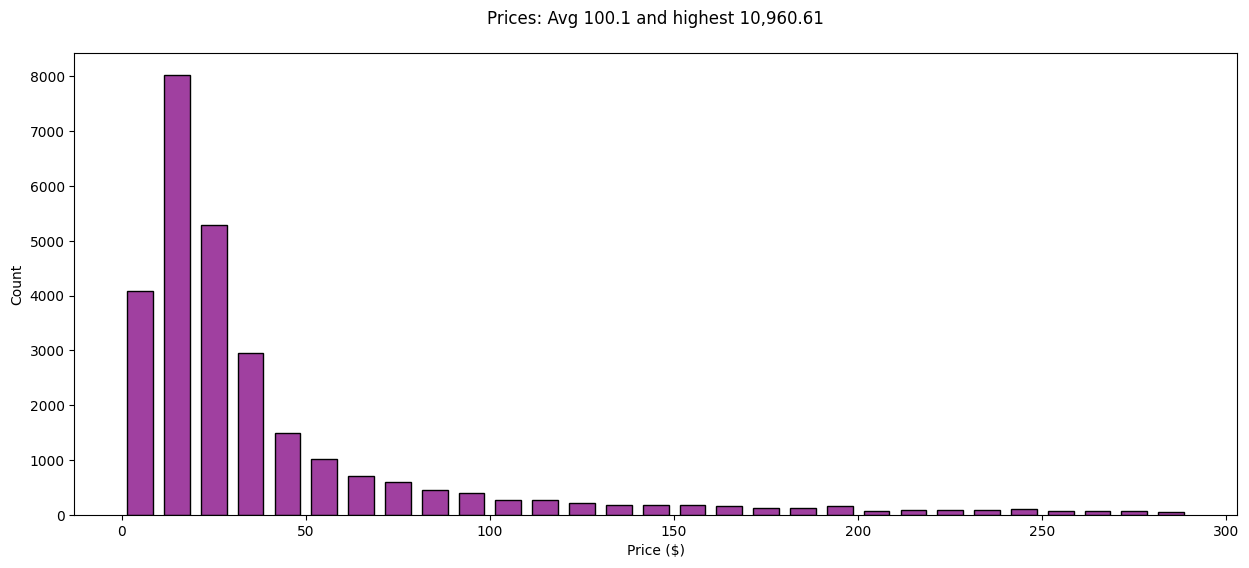

In [ ]:
prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
sns.histplot(prices, shrink=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

In [ ]:
CHUNK_SIZE = 1000
MIN_PRICE = 0.5
MAX_PRICE = 999.49

class ItemLoader:


    def __init__(self, name):
        self.name = name
        self.dataset = None

    def from_datapoint(self, datapoint):

        try:
            price_str = datapoint['price']
            if price_str:
                price = float(price_str)
                if MIN_PRICE <= price <= MAX_PRICE:
                    item = Item(datapoint, price)
                    return item if item.include else None
        except ValueError:
            return None

    def from_chunk(self, chunk):

        batch = []
        for datapoint in chunk:
            result = self.from_datapoint(datapoint)
            if result:
                batch.append(result)
        return batch

    def chunk_generator(self):

        size = len(self.dataset)
        for i in range(0, size, CHUNK_SIZE):
            yield self.dataset.select(range(i, min(i + CHUNK_SIZE, size)))

    def load_in_parallel(self, workers):

        results = []
        chunk_count = (len(self.dataset) // CHUNK_SIZE) + 1
        with ProcessPoolExecutor(max_workers=workers) as pool:
            for batch in tqdm(pool.map(self.from_chunk, self.chunk_generator()), total=chunk_count):
                results.extend(batch)
        for result in results:
            result.category = self.name
        return results

    def load(self, workers=8):

        start = datetime.now()
        print(f"Loading dataset {self.name}", flush=True)
        self.dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_{self.name}", split="full", trust_remote_code=True)
        results = self.load_in_parallel(workers)
        finish = datetime.now()
        print(f"Completed {self.name} with {len(results):,} datapoints in {(finish-start).total_seconds()/60:.1f} mins", flush=True)
        return results

In [ ]:
items = ItemLoader("Appliances").load()

Loading dataset Appliances


100%|██████████| 95/95 [02:36<00:00,  1.65s/it]


Completed Appliances with 28,625 datapoints in 2.7 mins


In [ ]:
print(items[1].prompt)

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.00


In [ ]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [ ]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())


Loading dataset Automotive


meta_Automotive.jsonl:   0%|          | 0.00/5.35G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 2004/2004 [1:21:18<00:00,  2.43s/it]


Completed Automotive with 911,688 datapoints in 100.0 mins
Loading dataset Electronics


meta_Electronics.jsonl:   0%|          | 0.00/5.25G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 1611/1611 [46:40<00:00,  1.74s/it]


Completed Electronics with 443,473 datapoints in 69.8 mins
Loading dataset Office_Products


meta_Office_Products.jsonl:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 711/711 [23:34<00:00,  1.99s/it]


Completed Office_Products with 240,394 datapoints in 33.2 mins
Loading dataset Tools_and_Home_Improvement


meta_Tools_and_Home_Improvement.jsonl:   0%|          | 0.00/4.85G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 1474/1474 [55:41<00:00,  2.27s/it]


Completed Tools_and_Home_Improvement with 541,051 datapoints in 77.1 mins
Loading dataset Cell_Phones_and_Accessories


meta_Cell_Phones_and_Accessories.jsonl:   0%|          | 0.00/4.02G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 1289/1289 [28:30<00:00,  1.33s/it]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 41.4 mins
Loading dataset Toys_and_Games


meta_Toys_and_Games.jsonl:   0%|          | 0.00/2.64G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 891/891 [32:44<00:00,  2.20s/it]


Completed Toys_and_Games with 340,479 datapoints in 44.8 mins
Loading dataset Appliances


100%|██████████| 95/95 [02:58<00:00,  1.88s/it]


Completed Appliances with 28,625 datapoints in 3.3 mins
Loading dataset Musical_Instruments


meta_Musical_Instruments.jsonl:   0%|          | 0.00/632M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 214/214 [06:39<00:00,  1.86s/it]


Completed Musical_Instruments with 66,829 datapoints in 8.8 mins


In [ ]:
print(f"A grand total of {len(items):,} items")

A grand total of 2,811,408 items


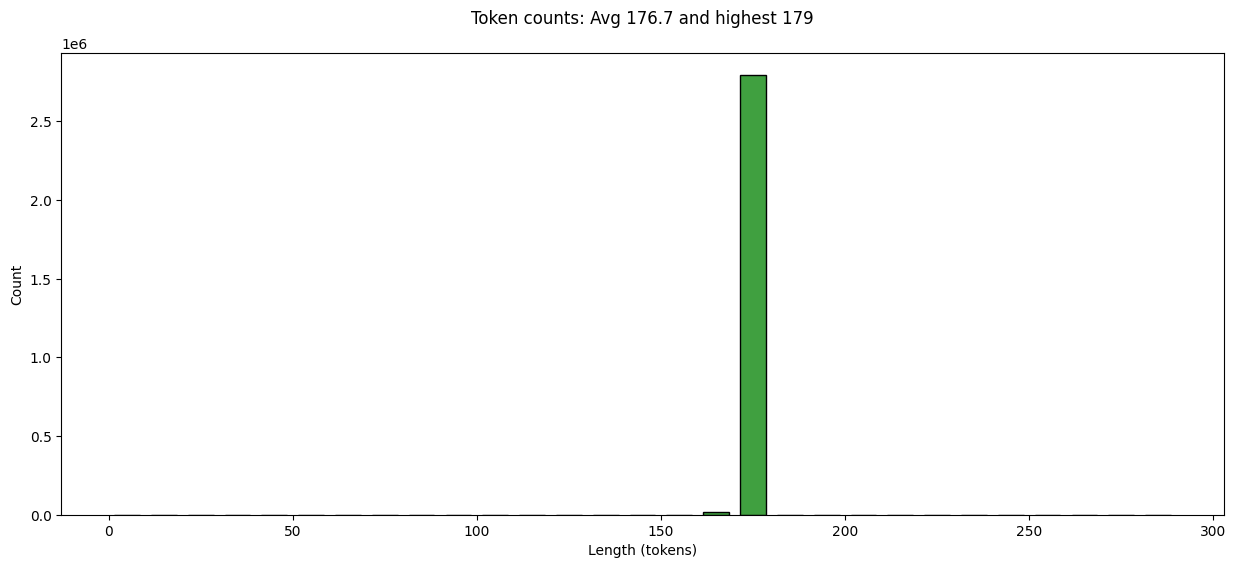

In [ ]:
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
sns.histplot(tokens, shrink=0.7, color="green", bins=range(0, 300, 10))
plt.show()

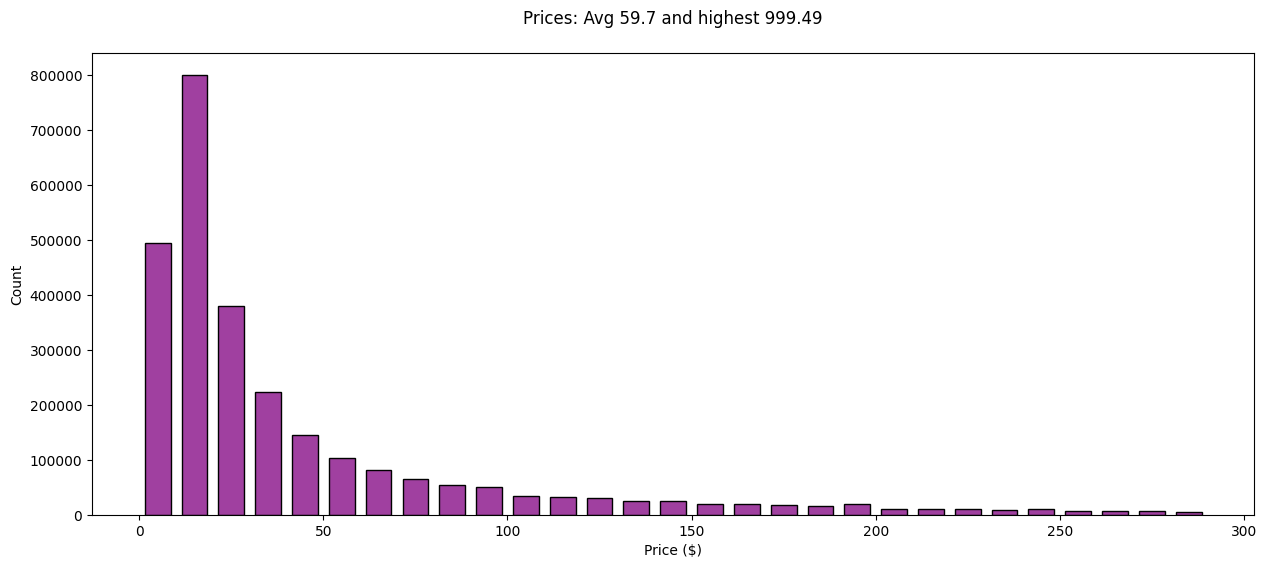

In [ ]:
prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
sns.histplot(prices, shrink=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

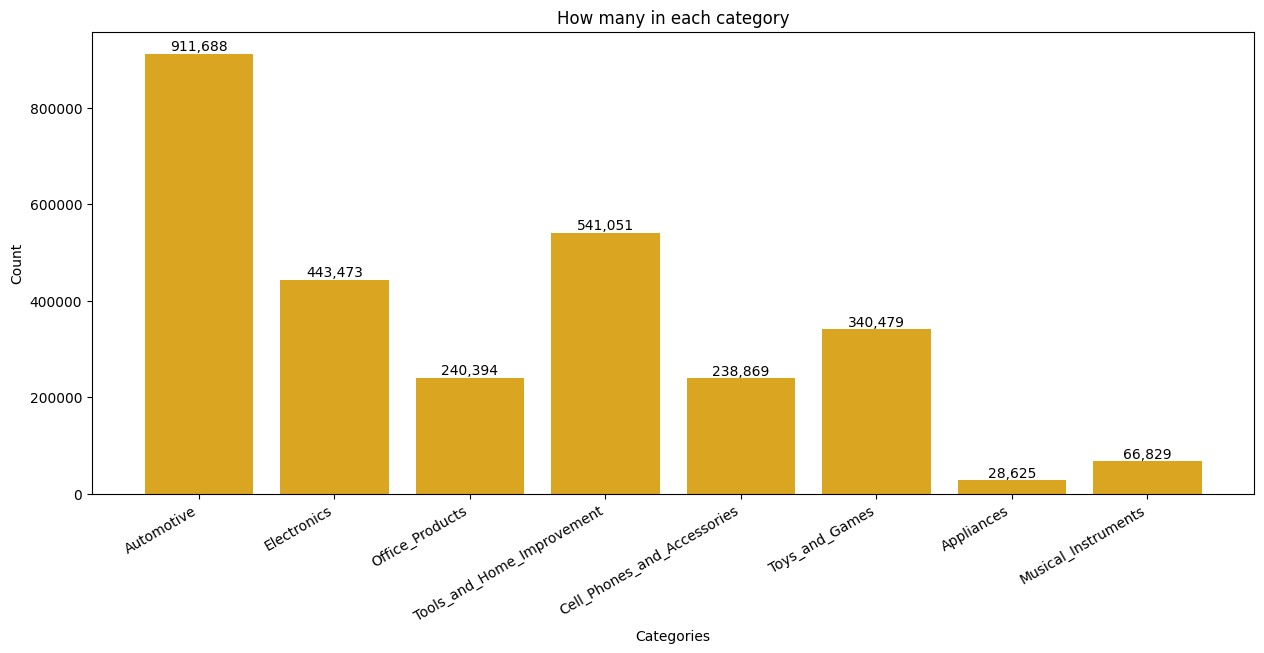

In [ ]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

plt.show()

In [ ]:
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [ ]:
np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 408,635 items in the sample


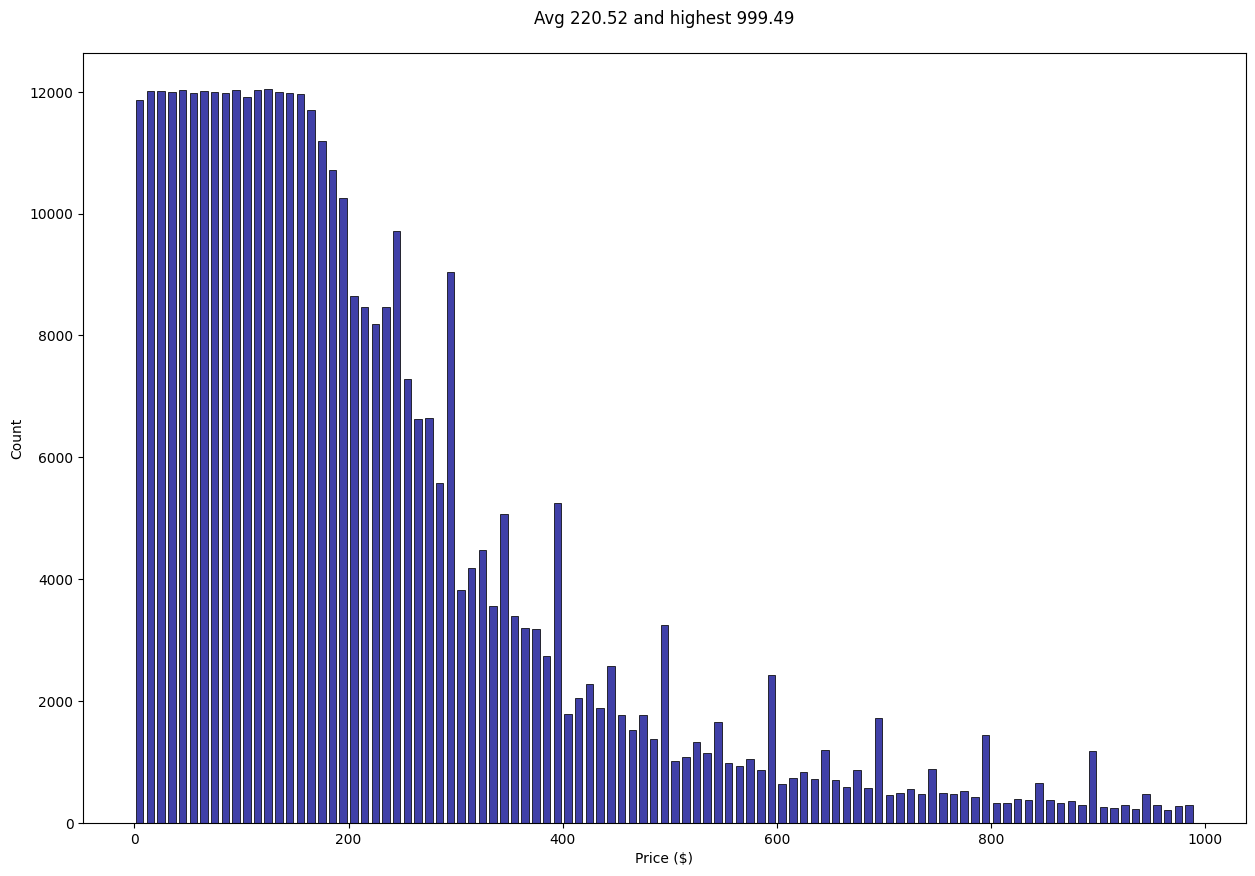

In [ ]:
prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
sns.histplot(prices, shrink=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

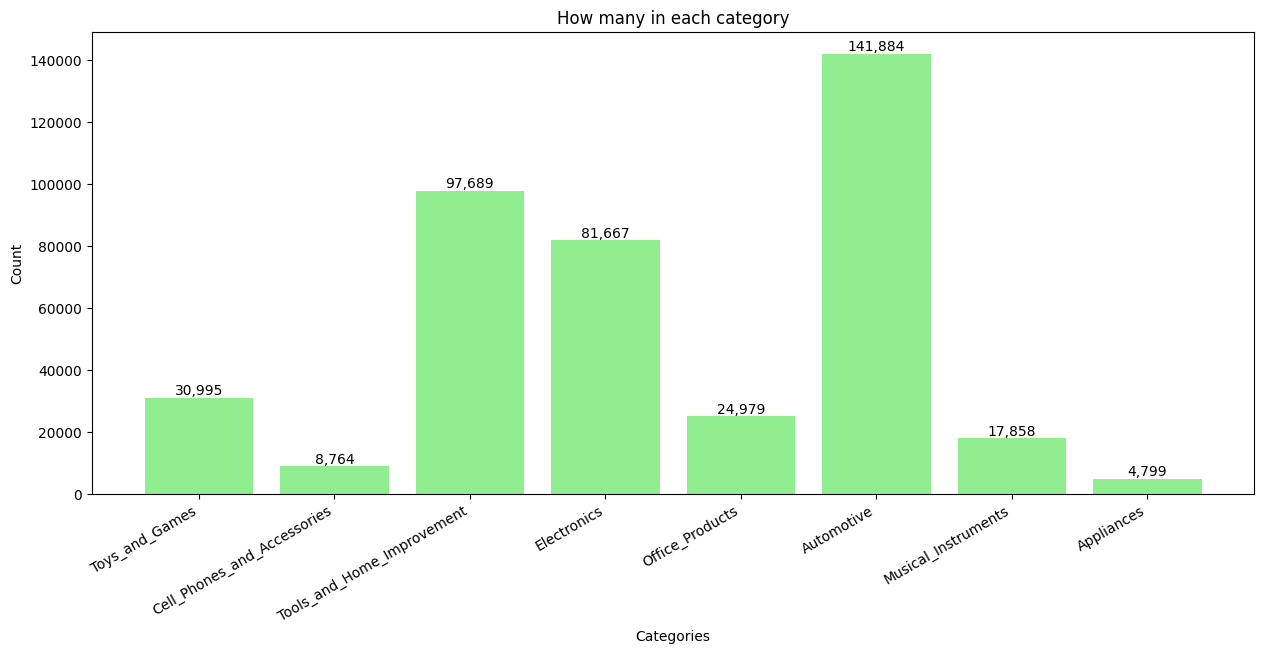

In [ ]:
category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

plt.show()

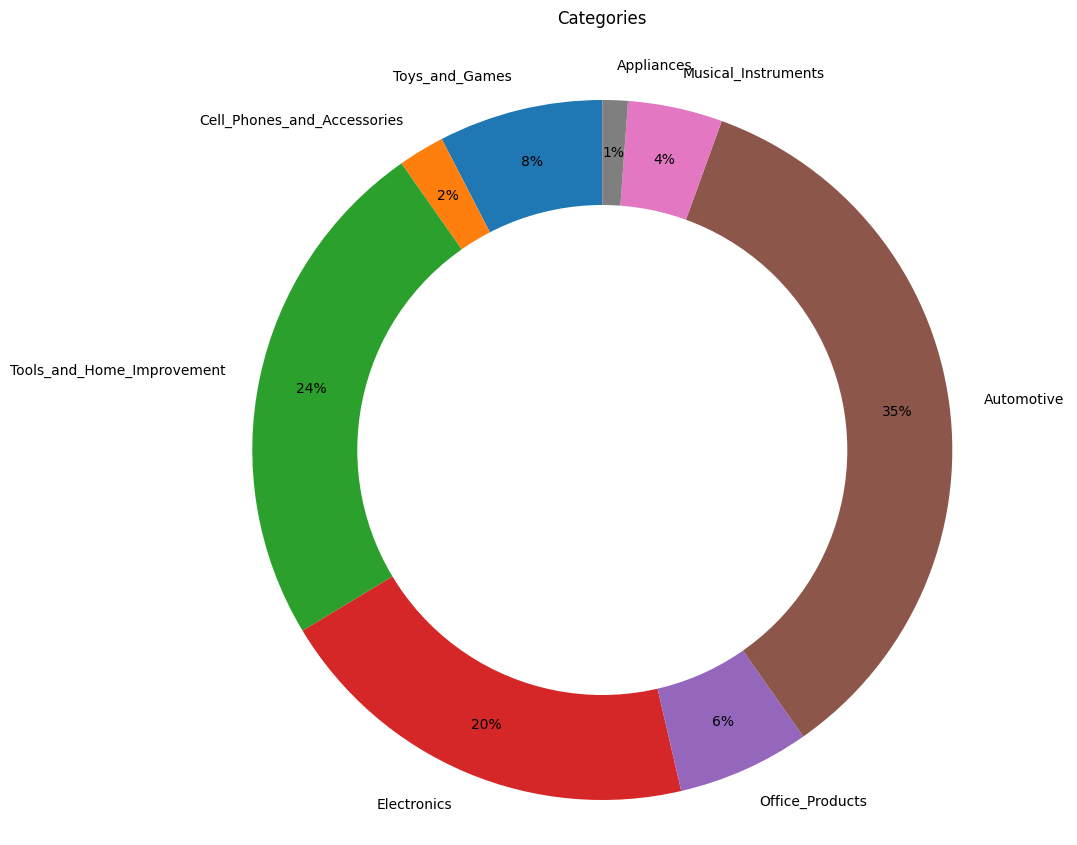

In [ ]:
plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90,
       labeldistance=1.1, pctdistance=0.85)

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories', pad=30)

plt.axis('equal')

plt.show()

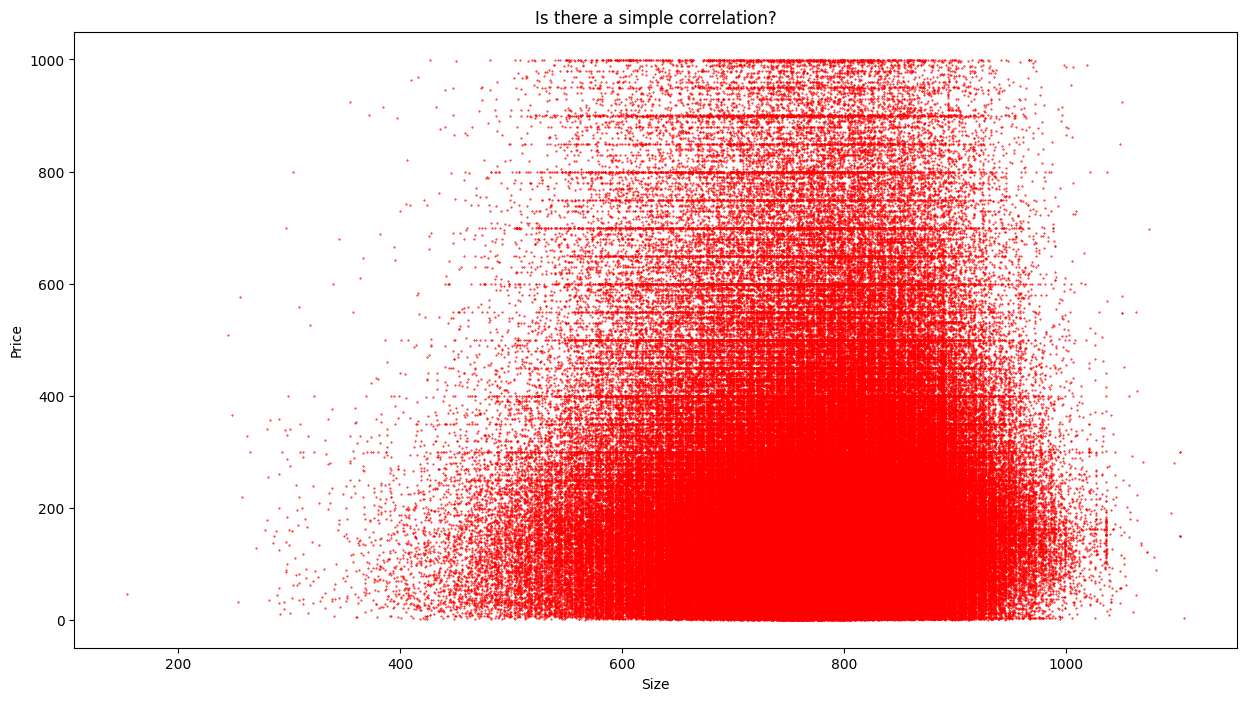

In [ ]:
sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

plt.show()

In [ ]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [ ]:
report(sample[398000])

How much does this cost to the nearest dollar?

MonoRS Coilovers Lowering Kit Made For Scion FRS Fully Adjustable, Set of 4
MonoRS Coilover damper kit by Godspeed Project are intermediate suspension upgrade setup for daily and Sunday club racing. Lowering your car with improved springs over factory and paired with Mono-tubo shocks with valving that allows 32 levels of rebound adjustment to improve handling without sacrifice comfort. Ride height can easily be adjusted by twisting the lower mount bracket. In order to keep weight gain at the minimum, most of attachments and accessories are CNC machined from billet aluminum. Koyo bearings are used when camber plate top mount is applicable depends on car models. To assure that our customers are getting high quality products, MonoRS coilovers are covered by 12 months limited warranty by the manufacturer from

Price is $765.00
[279, 14290, 505, 271, 7117, 374, 400, 22240, 13, 410]
[' the', ' manufacturer', ' from', '\n\n', 'Price', ' is', ' $

In [ ]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


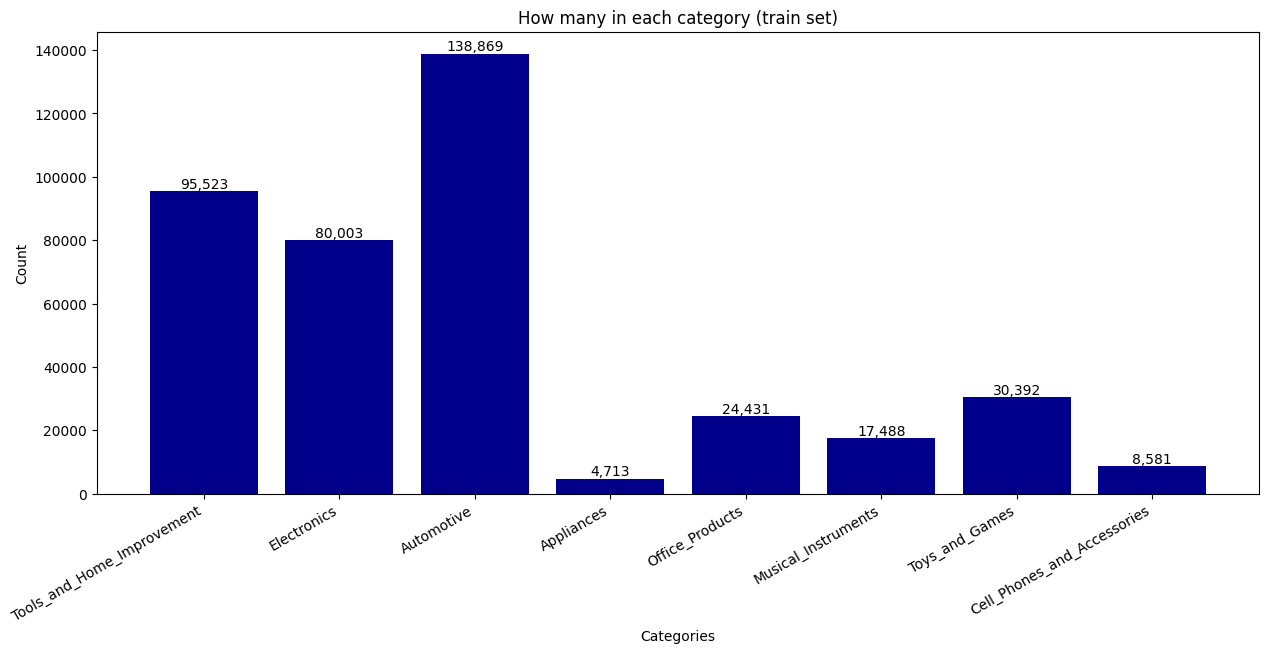

In [ ]:
category_counts = Counter()
for item in train:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="darkblue")

plt.title('How many in each category (train set)')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

plt.show()

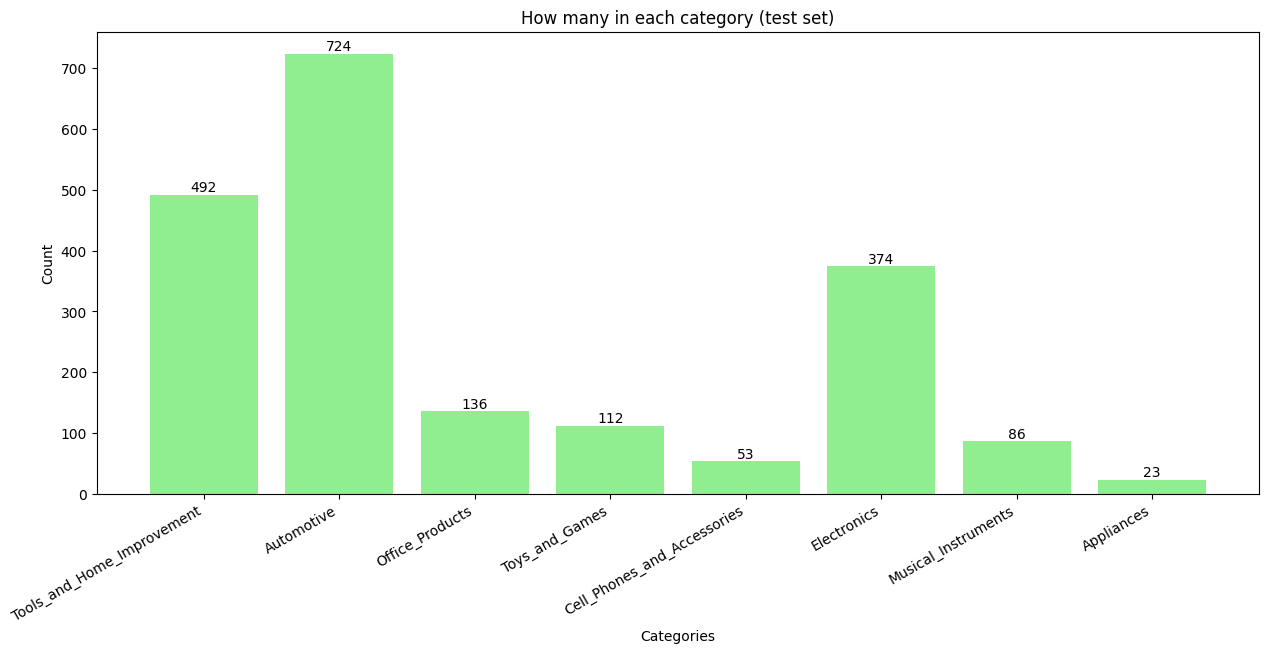

In [ ]:
category_counts = Counter()
for item in test:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

plt.title('How many in each category (test set)')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

plt.show()

In [ ]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [ ]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $


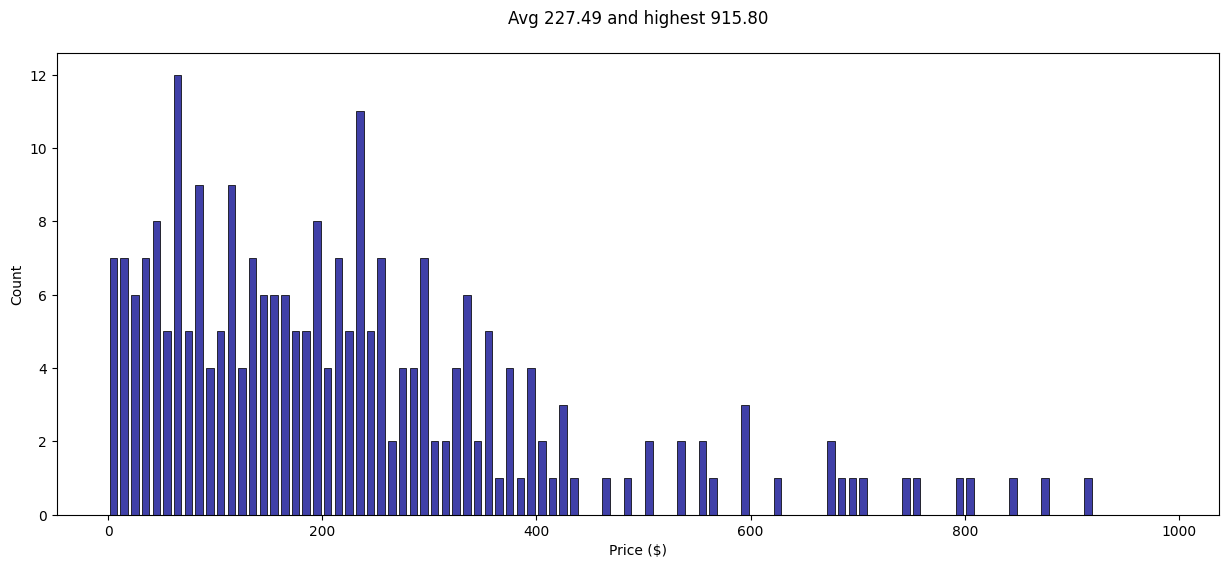

In [ ]:
prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
sns.histplot(prices, shrink=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

In [ ]:
with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)


"\nwith open('train.pkl', 'wb') as file:\n    pickle.dump(train, file)\n\nwith open('test.pkl', 'wb') as file:\n    pickle.dump(test, file)\n"

In [ ]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [ ]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [ ]:
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset.save_to_disk('/content/drive/My Drive/my_dataset')

Mounted at /content/drive


Saving the dataset (0/1 shards):   0%|          | 0/400000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]